# Devoir 1

## Initialisations
### Importation des modules

In [275]:
import numpy as np
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import scipy.fftpack as fftpack
import scipy

import matplotlib.pyplot as plt
import matplotlib.image as img 
import time
%matplotlib inline

### Fonction Utile

In [6]:
def printImage(x, width=28, height=28):
    plt.imshow(x.reshape((height, width)), cmap='gray')


## Definition des listes de données mnist


In [182]:
f = lambda x : 1 if x > 128 else 0
normalize = np.vectorize(f)

mnist_train = np.loadtxt("mnist_train.csv", delimiter=",", skiprows=1)
mnist_train[:, 1:] = normalize(mnist_train[:,1:])

mnist_test = np.loadtxt("mnist_test.csv", delimiter=",", skiprows=1)
mnist_test[:, 1:] = normalize(mnist_test[:,1:])



In [8]:
n_train_data = mnist_train.shape[0]

n_test_data = mnist_test.shape[0]

ndim = mnist_train.shape[1] - 1
img_dim = int(ndim ** (1./2.))

## Traitement par centroid

Pour ce traitement, on commence par calculer le centroid de l'image en calculant la moyenne des coordonées x, y des pixels noires de l'image. Ensuite, on subdivise l'image n fois. Celà donne $2^n$ sous images. Pour chacune de ces sous images, on calcul le centroid de celle ci de la même manière que pour l'image complète. Ensuite, on garde dans un vecteur les centroides d'une sous-image corriger avec le centroide de l'image complète. ceci nous donne un vecteur de dimension $2^n * 2$. n, dans ce model, est un hyperparamètre.

L'idée derrière cette methode est que si on regarde pixel par pixel deux images d'un même chiffre, on obtient beaucoup de différence. En prenant des sous-sections plus large, on élimine les petites variations de pixels et on garde une forme plus globale. 

Dans l'algorithme, on applique aussi deux transformations pour esseyer d'uniformiser les données. D'abord, on recentre les données par rapport au centroid. Ensuite, on fait une transformation d'échelle pour que les données aient à peut près toutes la même taille. La transformation d'échelle prend les données les plus éloignés en x et en y et applique la transformation qui emmène ces points aux coordonnées 14 ou -14 dans les deux directions.

Par la suite la distance euclidienne sera utilisé pour comparer les nouveaux vecteurs obtenues

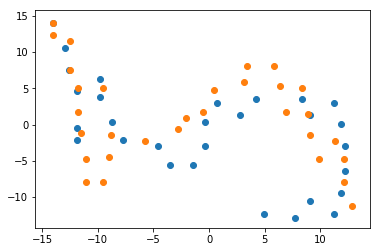

In [207]:
#retourne le centroid des point noire d'une image en coordonné (vertical, horizontale)
def get_center(x):
    dx, dy = x.shape[0], x.shape[1]
    vect = np.zeros((dx*dy, 2))
    k = 0
    result = np.zeros((2))
    var = 0
    for i in range(dy):
        for j in range(dx):
            if x[i, j] == 1:
                result += np.array([i, j])
                k += 1
    # on retourne le centroid ou (-1, -1) si l'image est vide
    return result / k if k > 0 else np.zeros(2) - 1


#calcul la distance des centroid des différentes 
#sous-section de l'image avec le centroid de limage total, 
#le nombre de separation doite etre un diviseur de 28
def grid(x, n=2):
    ndim = 28
    img = x.reshape((28, 28))
    delta = ndim // n #saut de coordonné entre les sous parties
    center = get_center(img) # centre de l'image
    #initialisation des centroids des sous parties
    centroids = np.zeros((n, n, 2)) 
    for i in range(n):
        for j in range(n):
            i_square = i*delta #origine verticale du carré 
            j_square = j*delta #origine horizontale du carré
            #centroid de l'image
            cent = get_center(img[i_square:(i+1)*delta, j_square:(j+1)*delta]) 
            #cas où le carré est vide
            if cent[0] == -1:
                """on appplique une pénalité de -15 (hors de l'image) si le carré est vide.
                     Pour que la pénalité soit relative à la position du carré (afin que la 
                     pénalité soit consistante quand on calculera la distance entre deux image)
                     on applique la pénalité relativement à la position du carré"""
                centroids[i, j] = np.zeros((2)) - 15 * np.array([n - i, n - j])
            #cas où le entroid existe
            else:
                 
                centroids[i, j] = np.array([i_square, j_square]) + cent - center
                
    #résultat des centroid transformer en un vecteur de n**2 donné bidimensionelle
    a_centroids = centroids.reshape((n**2, 2))
    #calcul des coordoné extreme
    max_v = np.max(np.abs(a_centroids[a_centroids[:,0] > -15, 0]))
    
    max_h = np.max(np.abs(a_centroids[a_centroids[:,1] > -15, 1]))
    max_v_ratio = 1.
    max_h_ratio = 1.
    #le centroid doit être différent de (0, 0) pour appliquer un changement d'échelle
    if max_v > 0:
        max_v_ratio = 14 / max_v
        
    if max_h > 0:
        max_h_ratio = 14 / max_h
    
    a_centroids *= np.array([max_v_ratio, max_h_ratio])
    return a_centroids.reshape((n**2*2)) #on transforme en un vecteur 

#applique grid a une liste de donné
def to_grids(x, n_sub=2):
    
    n_data = x.shape[0]
    
    n_sub_dim = n_sub**2*2
    result = np.zeros((n_data, n_sub_dim))
    for i in range(n_data):
        result[i] = grid(x[i], n_sub) #les donné sont transformer en vecteur
        
    return result



mnist_class = [mnist_train[mnist_train[:,0] == i, 1:] for i in range(10)]

#mnist_class_mean = np.array([np.mean(datas, axis=0) for datas in mnist_class])

#teste pour la chiffre 5
test1 = grid(mnist_class[5][10], 12)
test2 = grid(mnist_class[5][0], 12)

#on élimine le donné hors de l'écran
test1 = test1[np.abs(test1) < 15]
test2 = test2[np.abs(test2) < 15 ]
 
plt.scatter(test1.reshape(test1.shape[0]//2, 2)[:, 0], test1.reshape(test1.shape[0]//2, 2)[:, 1])
plt.scatter(test2.reshape(test2.shape[0]//2, 2)[:, 0], test2.reshape(test2.shape[0]//2, 2)[:, 1])
plt.show()


On peut voire qu'on obtient une forme générale similaire pour les deux valuer de 5

## Algorithmes

Pour Commencer nous appliquon la transformation aux donné. Dans ce cas là nous avon chosi un exmaplaire de 6000 donné d'entrainement. Le nombre de subdivision est fixé à 14.

In [253]:
n_sub_div = 14 #nombre de subdivision d'image (hyperparamètre)
n_sub_dim = n_sub_div**2*2 #dimension du vecteur résultant en fonction du nombre de subdivision
n_examples = 6000
#transformation des donné mnist (peu prendre un certain temps)
#n_example = 5000


# traitment en série de centroid

grid_train = to_grids(mnist_train[:n_examples, 1:], n_sub_div)

grid_test = to_grids(mnist_test[:, 1:], n_sub_div)

#initialisation des nouveau vecteur de donné
mnist_train_mod = np.zeros((n_examples, n_sub_dim + 1))
mnist_test_mod = np.zeros((n_test_data, n_sub_dim + 1))

#on place les donné
mnist_train_mod[:, 1:] = grid_train

mnist_test_mod[:, 1:] = grid_test

#on place les label dans le premier entré de chaque vecteur de donné
mnist_train_mod[:, 0] = mnist_train[:n_examples, 0]
mnist_test_mod[:, 0] = mnist_test[:, 0]

#print(mnist_train_mod[0])

### K-medoid
Voici une comparaison entre k-medoid avec la distance euclidienne et et avec la distance définit plus haut. Pour comparé les résultat les même médoids initiaux sont utilisé pour les deux algorithme. Il sont choisit aléatoirement parmi le données. Pour représenté les dix chiffres on a choisi un k = 10.

Temps d'éxécution de l'algorithme k-medoid pour le cas de centroid: 0.6161229610443115
Temps d'éxécution de l'algorithme k-medoid pour le cas Euclidien: 0.9392445087432861
Medoid intitaux: [2997 3768 1641  255  186 2272 1637 2592 1908  143]
Image des medoids obtenus par les donné des distance des centroid dans la base original


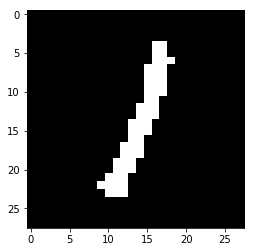

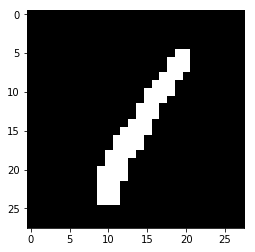

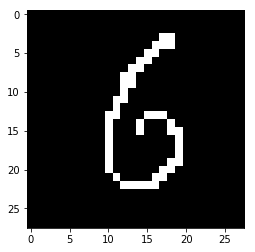

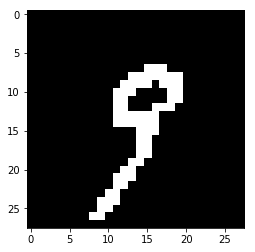

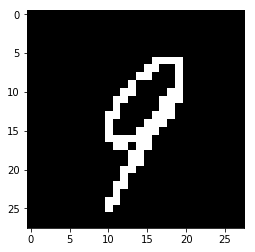

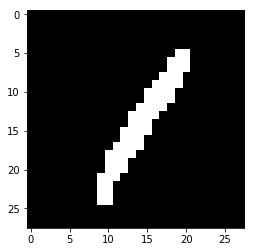

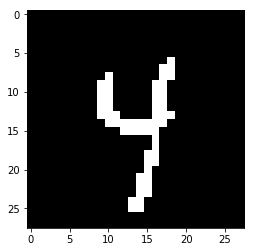

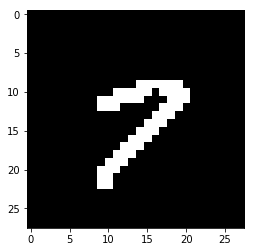

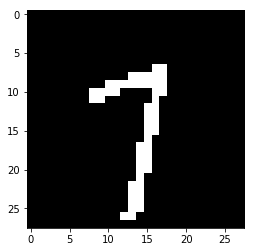

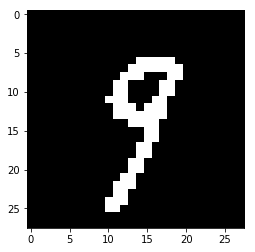

Image des medoids obtenue par la distance euclidienne entre le donnés


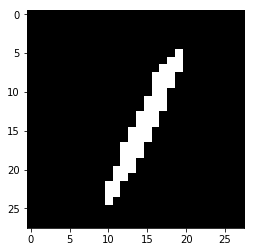

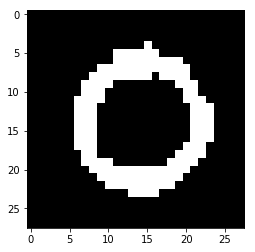

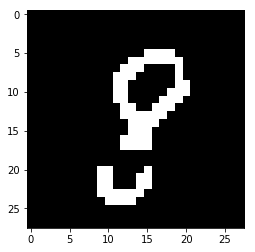

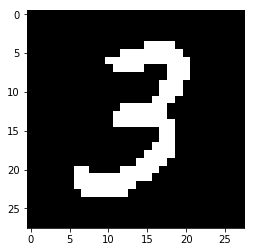

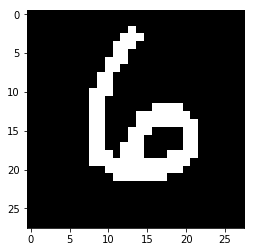

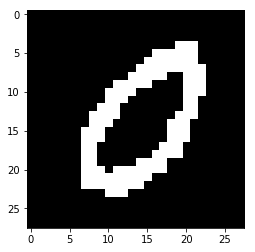

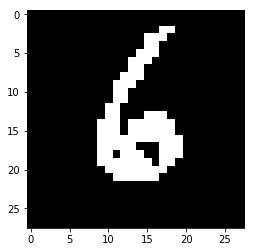

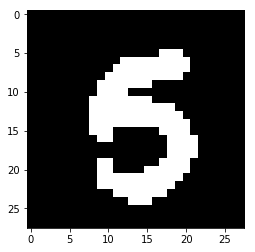

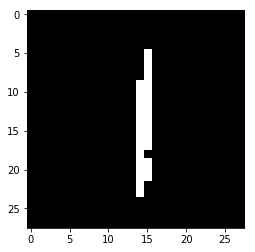

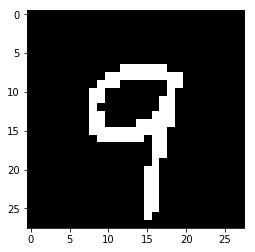

In [286]:
n_data = 4000 # nombre de donne pour faire le teste

#on retire les labels au donné pour seulement garder les composantes
mnist_mod_data = mnist_train_mod[:n_data, 1:]
mnist_data = mnist_train[:n_data, 1:]

# matrice de distance enre les donné transformer
start = time.time()
d_mod = metrics.pairwise_distances(mnist_mod_data, mnist_mod_data)
end = time.time()
print("Temps d'éxécution de l'algorithme k-medoid pour le cas de centroid: " + str(end - start))

#matrice de distance euclidienne
start = time.time()
d_euc = metrics.pairwise.euclidean_distances(mnist_data, mnist_data)
end = time.time()
print("Temps d'éxécution de l'algorithme k-medoid pour le cas Euclidien: " + str(end - start))


np.random.seed(2555)

# initialize les medoids
initial_medoids = np.zeros((10), dtype="int32")
for i in range(10):
    n = np.random.randint(n_data)
    while n in initial_medoids:
        n = np.random.randint(n_data)
        
    initial_medoids[i] = n

print("Medoid intitaux: " + str(initial_medoids))



#cas donné transformer



k_mod = kmedoids(d_mod, initial_medoids, data_type='distance_matrix')


k_mod.process()


medoids = k_mod.get_clusters()[0]


print("Image des medoids obtenus par les donné des distance des centroid dans la base original")
for cent in mnist_data[medoids[:10]] :    
    plt.figure()
    printImage(cent)

plt.show()
# cas eucliden
k_euc = kmedoids(d_euc, initial_medoids, data_type='distance_matrix')


k_euc.process()


medoids = k_euc.get_medoids()


print("Image des medoids obtenue par la distance euclidienne entre le donnés")
for cent in mnist_data[medoids[:10]] :
    plt.figure()
    printImage(cent)

plt.show()
    

On observe que dans les deux cas les medoid obtenue 

#### Evaluation

On compare les scores silouhette de k-medoid pour les deux distances.

In [272]:
"""fonction qui transforme un les donné séparé en cluster 
    pour obtenir la liste des cluster associé a chaque donné"""

def prediction(clusters, datasize):
    predict = np.zeros((datasize), dtype="int32")
    for i in range(len(clusters)):
        predict[clusters[i]] = i
    return predict

predictions_mod = prediction(k_mod.get_clusters(), mnist_mod_data.shape[0])
#print(predictions_fft)
print("Score silhouette de la distance centroid: " + str(metrics.silhouette_score(mnist_mod_data, predictions_mod)))

predictions_euc = prediction(k_euc.get_clusters(), mnist_data.shape[0])
print("Score silhouette de la distance centroid :" + str(metrics.silhouette_score(mnist_data, predictions_euc)))

Score silhouette de la distance centroid: 0.0520064326691
Score silhouette de la distance centroid :0.0438720778433


### Partition binaire
Maintenant on évalue les deux distance pour l'algorithme de partition binaire. On évalue aussi le score silouhette. 

In [273]:
#cas donné transformer
clustering_mod = AgglomerativeClustering(n_clusters=10, linkage="average").fit(mnist_mod_data)


# cas normal
clustering_euc = AgglomerativeClustering(n_clusters=10, linkage="average").fit(mnist_data)

#prediction
predictions_mod = clustering_mod.labels_
print("Score silhouette de la distance centroid: " + str(metrics.silhouette_score(mnist_mod_data, predictions_mod)))


predictions_euc = clustering_euc.labels_
print("Score silhouette de la distance centroid :" + str(metrics.silhouette_score(mnist_data, predictions_euc)))

centers = np.zeros((28))

Score silhouette de la distance centroid: 0.63249724249
Score silhouette de la distance centroid :0.0557979722227


Les regroupement semble beaucoup mieux définit avec la nouvelle distance si on se fi au score silouhette. la distance semble donc mieux fonctionner avec le partitionnement binaire qu'avec k-médoid.

In [270]:
from sklearn.neighbors import KNeighborsClassifier

mnist_train1 = mnist_train_mod[:2000]
mnist_test1 = mnist_test_mod[:1000]
mnist_train2 = mnist_train[:2000]
mnist_test2 = mnist_test[:1000]
#in_euc = lambda x, y : -(np.sqrt(np.sum((x - y)**2)))
knn_fft = KNeighborsClassifier(4).fit(mnist_train1[:, 1:], mnist_train1[:, 0])
print(knn_fft.score(mnist_test1[:, 1:], mnist_test1[:, 0]))
knn_euc = KNeighborsClassifier(6).fit(mnist_train2[:, 1:], mnist_train2[:, 0])
print(knn_euc.score(mnist_test2[:, 1:], mnist_test2[:, 0]))

0.869
0.832
